<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/02_classification_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classification problems

Similar to how we can walk from linear regression to a nonlinear regression neural network, we can make the same walk from logistic regression to a nonlinear classification network. 

Recall that logistic regression is a popular algorithm for classification problems that finds a linear solution to try to separate $C$ classes.

##Setup

In [ ]:

from sklearn.datasets import make_moons

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

import time
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from idlmam import *

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
def move_to(obj, device):
  """
  obj: the python object to move to a device, or to move its contents to a device
  device: the compute device to move objects to
  """
  if hasattr(obj, "to"):
      return obj.to(device)
  elif isinstance(obj, list):
      return [move_to(x, device) for x in obj]
  elif isinstance(obj, tuple):
      return tuple(move_to(list(obj), device))
  elif isinstance(obj, set):
      return set(move_to(list(obj), device))
  elif isinstance(obj, dict):
      to_ret = dict()
      for key, value in obj.items():
          to_ret[move_to(key, device)] = move_to(value, device)
      return to_ret
  else:
      return obj

##Toy dataset

To make our lives easier, we use the built-in `TensorDataset` object to wrap our current data. 

This only works if we can fit all of our data into RAM.

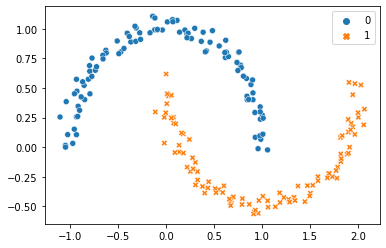

In [6]:
# let's generate moons dataset
X, y = make_moons(n_samples=200, noise=0.05)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y)

In [7]:
classification_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32),
    torch.tensor(y, dtype=torch.long)  # because the labels are absolute so represented as a single integer
)
training_loader = DataLoader(classification_dataset)

##The training loop

In [8]:
def train_network(model, loss_func, data_loader, epochs=20, device="cpu"):
  # create the SGD optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch"):
    # Put the model in training mode
    model = model.train()
    running_loss = 0.0

    # iterating through all the inputs (features) and labels (target)
    for inputs, labels in tqdm(data_loader, desc="Batch", leave=False):
      # Move the batch of data to the device we are using
      inputs = move_to(inputs, device)
      labels = move_to(labels, device)

      #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
      #Otherwise, it will have old information from a previous iteration
      optimizer.zero_grad()

      # perform the prediction
      y_hat = model(inputs)

      # Compute loss
      loss = loss_func(y_hat, labels)

      # compute the gradient
      loss.backward()

      # Now we just need to update all the parameters
      optimizer.step()

      # just grabbing some information we would like to have
      running_loss += loss.item()

##Defining model

In [9]:
in_features = 2
out_features = 2

model = nn.Linear(in_features, out_features)

##Training network

In [ ]:
loss_func = nn.CrossEntropyLoss()

train_network(model, loss_func, training_loader, epochs=50)

With our model trained, let’s visualize the results.

In [13]:
def visualize_softmax(X, y, model, title=None):
  x_min = np.min(X[:, 0]) - 0.5
  x_max = np.max(X[:, 0]) + 0.5
  y_min = np.min(X[:, 0]) - 0.5
  y_max = np.max(X[:, 0]) + 0.5

  xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing="ij")
  xy_v = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))

  with torch.no_grad():
    logits = model(torch.tensor(xy_v, dtype=torch.float32))
    # perform the conversation from raw outputs into actual probability distributions
    y_hat = F.softmax(logits, dim=1).numpy()

  cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
  ax = plt.gca()
  sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
  if title is not None:
      ax.set_title(title)

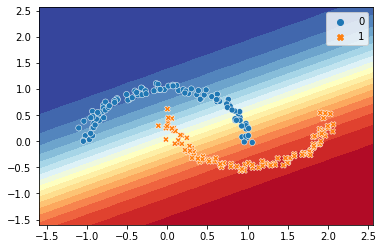

In [14]:
visualize_softmax(X, y, model)

We can now see the results of our model on this data. Overall, it’s a decent job.

Now we do the same we did with our regression problem: add a hidden layer to
increase the complexity of the neural network.

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

train_network(model, loss_func, training_loader, epochs=250)

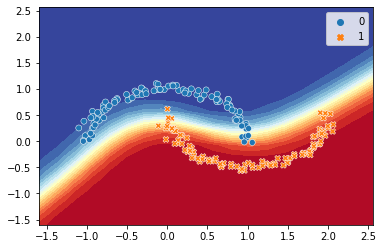

In [17]:
visualize_softmax(X, y, model)

The results appear to be worth it, though: if we
look at a plot of our data, we see that the model has higher confidence for the regions
that are unambiguously circles or crosses. 

You can also see that the threshold is starting
to bend and curve as the neural network learns a nonlinear separation between the two classes.